In [1]:
import pandas as pd
import numpy as np
import math
import datetime

# Data gathering and refining steps:

Gathering data here

In [2]:
train = pd.read_csv('train.csv')
time_ids = pd.read_csv('time_id_reference.csv')
book = pd.read_parquet('order_book_feature.parquet')

Re indexing the book as per time stamp so its easier to handle in calculating volatility.
Also Calculating the WAP

In [3]:
book['ts'] = book['time_id'] * 1800 + book['seconds_in_bucket']
book['wap'] = (book['bid_price1'] * book['ask_size1'] +
                                book['ask_price1'] * book['bid_size1']) / (
                                       book['bid_size1']+ book['ask_size1'])
data = book.copy()
book.set_index('ts', inplace=True)
book.head()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap
ts,,,,,,,,,,,,
21601.0,8382,12,1.0,722.17,722.63,722.15,722.64,100,25,25,20,722.538000
21602.0,8382,12,2.0,722.18,722.88,722.17,722.98,25,10,66,100,722.680000
21603.0,8382,12,3.0,722.33,722.65,722.27,722.74,25,120,200,25,722.385172
21604.0,8382,12,4.0,722.68,722.98,722.48,723.00,25,100,25,1,722.740000
21605.0,8382,12,5.0,722.52,722.96,722.42,722.97,125,20,3,110,722.899310


# Beta Calculation

Below is the function used for calculating the Beta of the stock with S&P Index. Beta is defined as Covariance/(std. deviation of stock * std. deviation of S&P)

Stock Intersect function is used to find common time IDs in the data given for the S&P index and the stock. So we only consider the time series data for the intersection of the 2 sets of data.

In [4]:
def stockIntersect(stock, spy):
    stock = stock.reset_index()
    spy = spy.reset_index()
    
    i = 0
    j = 0
    len_i = len(stock['log_return'])-1 
    len_j = len(spy['log_return'])-1 
    resStockWAP = []
    resSpyWAP = []
    
    while i < len_i and j < len_j:
        if (stock['seconds_in_bucket'][i] == spy['seconds_in_bucket'][j]):
            resStockWAP.append(stock['wap'][i])
            resSpyWAP.append(spy['wap'][j])
            i += 1
            j += 1
        elif stock['seconds_in_bucket'][i] < spy['seconds_in_bucket'][j]:
            i += 1
        elif stock['seconds_in_bucket'][i] > spy['seconds_in_bucket'][j]:
            j += 1
    return resStockWAP, resSpyWAP

In [1]:
def betaCalc(book, stock_id, time_id, local):
    if stock_id == 50200:
        beta = 0
    else:
        data_stock = book.loc[book['stock_id'] == stock_id]
        data_spy = book.loc[book['stock_id'] == 50200]
        
        if local:
            data_stock = data_stock.loc[data_stock['time_id'] == time_id]
            data_spy = data_spy.loc[data_spy['time_id'] == time_id]

        stock_wap, spy_wap = stockIntersect(data_stock, data_spy)

        avg = np.average(stock_wap)
        stock_dev = np.subtract(stock_wap,avg)
        stock_std_dev = np.sqrt(np.sum(stock_dev**2))

        spy_avg = np.average(spy_wap)
        spy_dev = np.subtract(spy_wap,spy_avg)
        spy_std_dev = np.sqrt(np.sum(spy_dev**2))

        covariance = 0
        for i in range(len(stock_dev)):
            covariance += stock_dev[i] * spy_dev[i]

        beta = covariance/(stock_std_dev*spy_std_dev)

    return beta


# Best Beta Calculator

Calculates the most correlated stock from the list of stocks and returns the beta, stock_id

In [6]:
from collections import defaultdict

In [7]:
def bestBeta(book,stock_id,time_id):
    stock_id_data = [9323, 22675, 22951, 22729, 48219 , 22753, 22771, 104919, 50200, 8382]
    stockDict = defaultdict()
    for sID in stock_id_data:
        if sID != stock_id:
            stockDict[sID] = betaCalc2(book,stock_id,time_id,sID)
    
    maxBeta = 0
    maxBetasID = -1
    for key in stockDict.keys():
        if stockDict[key] >= maxBeta:
            maxBetasID = key
            maxBeta = stockDict[key]
    
    return maxBeta, maxBetasID

def betaCalc2(book, stock_id, time_id, compare_stock_id):
    if stock_id == compare_stock_id:
        beta = 0
    else:
        data_stock = book.loc[book['stock_id'] == stock_id]
        data_stock = data_stock.loc[data_stock['time_id'] == time_id]
        data_compare = book.loc[book['stock_id'] == compare_stock_id]
        data_compare = data_compare.loc[data_spy['time_id'] == time_id]

        stock_wap, compare_wap = stockIntersect(data_stock, data_compare)

        avg = np.average(stock_wap)
        stock_dev = np.subtract(stock_wap,avg)
        stock_std_dev = np.sqrt(np.sum(stock_dev**2))

        compare_avg = np.average(compare_wap)
        compare_dev = np.subtract(compare_wap,compare_avg)
        compare_std_dev = np.sqrt(np.sum(compare_dev**2))

        covariance = 0
        for i in range(len(stock_dev)):
            covariance += stock_dev[i] * compare_dev[i]

        beta = covariance/(stock_std_dev*compare_std_dev)

    return beta     

# Volatility Calculation code

# Weighted Average Volatility Estimator

Calculates volatility by splitting the 30 mins into 2 intervals of 10 and 20 mins. Takes a weighted average of weights 0.7 and 0.3 respectively

In [8]:
def averageTrades(tradeList):
    sum = 0
    quant = 0
    for trade in tradeList:
        quant += trade['quantity']
        sum += trade['price'] * trade['quantity']

    return sum / quant

In [9]:
# Turn book data into vol
def bookToVol(book, start, end):
    prev = None
    first = True
    logRSum = 0
    for ts in range(start, end):
        if ts in book.index:
            if first:
                prev = book.at[ts, 'wap']
                first = False
            else:
                curr = book.at[ts, 'wap']
                logRSum += (np.log(curr) - np.log(prev))**2
                prev = curr
    return np.sqrt(logRSum)

Weighted Average Volatility calculator for a stock on specific time ID

In [10]:
# Determine the price movement over a given timespan
def vol_calc(book, time_id, seconds, stock):
    # Setup variables
    # Period1 = 10 mins back, Period2 = 30mins back
    period1 = 600
    period2 = 1800
    # Setup lists that will contain the book waps for those periods
    thirtyToTenList = []
    tenToNowList = []
    # Take the subset of the book that relates to the stock we want to investigate
    stockBooks = book.loc[book['stock_id'] == stock]

    # Define the timestamps for our investigated periods
    lookback30 = {
            'start' : (time_id+1) * 1800 + seconds - period2,
            'end' : (time_id+1) * 1800 + seconds - period1
        }
    lookback10 = {
            'start' : (time_id+1) * 1800 + seconds - period1,
            'end' : (time_id+1) * 1800 + seconds
        }
        
    # Get the vol for the 30min to 10min lookback period
    thirtyToTenVol = bookToVol(stockBooks, lookback30['start'], lookback30['end'])
    
    # This one is for the 10min to now lookback period
    tenToNowVol = bookToVol(stockBooks, lookback10['start'], lookback10['end'])
    # Our formula :)
    return 0.7*tenToNowVol + 0.3*thirtyToTenVol

# General Vol Calculator

Uses Log returns - Basically Naive Model

In [11]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

data['log_return'] = data.groupby(['time_id','stock_id'], group_keys=False)['wap'].apply(log_return)
data = data[~data['log_return'].isnull()]
data.head()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,ts,wap,log_return
1,8382,12,2.0,722.18,722.88,722.17,722.98,25,10,66,100,21602.0,722.680000,0.000197
2,8382,12,3.0,722.33,722.65,722.27,722.74,25,120,200,25,21603.0,722.385172,-0.000408
3,8382,12,4.0,722.68,722.98,722.48,723.00,25,100,25,1,21604.0,722.740000,0.000491
4,8382,12,5.0,722.52,722.96,722.42,722.97,125,20,3,110,21605.0,722.899310,0.000220
5,8382,12,6.0,722.36,722.69,722.35,722.70,2,20,25,100,21606.0,722.390000,-0.000705


In [12]:
def gen_vol_calc(book,stock_id,time_id, beta):
    
    data_stock = book.loc[book['stock_id'] == stock_id]
    data_stock = data_stock.loc[data_stock['time_id'] == time_id]
    
    vol_stock = np.sqrt(np.sum(data_stock['log_return']**2))
    
    data_spy = book.loc[book['stock_id'] == 50200]
    data_spy = data_spy.loc[data_spy['time_id'] == time_id]
    
    vol_spy_curr = np.sqrt(np.sum(data_spy['log_return']**2))
    if stock_id != 50200:
#         beta = betaCalc(book,stock_id,time_id)
        if time_id != 12:
            data_spy_prev = book.loc[book['stock_id'] == 50200].copy()
            data_spy_prev = data_spy_prev.loc[data_spy_prev['time_id'] == time_id-1].copy()
            vol_spy_prev = np.sqrt(np.sum(data_spy_prev['log_return']**2))
        else:
            vol_spy_prev = 0
    else:
        beta = 0
        vol_spy_curr = 0
        vol_spy_prev = 0
    return vol_stock + beta*abs(vol_spy_curr-vol_spy_prev)
    

# EWMA Volatility Calculator

Estimates volatility using EWMA with a 10 sec window. EWM is a function of pandas library.

In [14]:
def ewma(data, stockId, time_id):
    stock = data.loc[data['stock_id'] == stockId]
    stock = stock.loc[stock['time_id'] == time_id]

    return stock['log_return'].ewm(span=10).std() * np.sqrt(len(stock['log_return']))

# Runner code/ Main starts below here

# R2 and RMSPE score calculator

In [18]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# Local beta volatility calculator

Returns all performance metrics for a given stock!

In [2]:
def calculate_performance(stock_id, data, train):
    modelled_vol = []
    y_true = train.loc[train['stock_id'] == stock_id]
    beta_dir_error_list = []
    y_true_indexed = y_true.set_index('time_id')
    spy_vol_prev = 0
    for tID in y_true['time_id']:
        beta = betaCalc(data, stock_id, tID, True)
        if beta > 0:
            beta = (-1) * beta
        spy_vol = ewma(data, 50200, tID).mean()
        base_vol = ewma(data, stock_id, tID).mean()
        beta_factor = beta * abs(spy_vol - spy_vol_prev)
        spy_vol_prev = spy_vol
        generated_vol = base_vol + beta_factor
        modelled_vol.append(generated_vol)
        if ((generated_vol - base_vol >= 0) != (y_true_indexed.at[tID, 'target'] - base_vol >= 0)):
            beta_dir_error_list.append(tID)
            
    r2_score_val = round(r2_score(y_true=y_true['target'], y_pred=modelled_vol), 3)
    rmspe_val = round(rmspe(y_true=y_true['target'], y_pred=modelled_vol), 3)
    beta_dir_effectiveness = round(len(beta_dir_error_list) / len(y_true), 3)
    
    return r2_score_val, rmspe_val, beta_dir_effectiveness, modelled_vol, beta_dir_error_list

# Data gen for metric testing

# Tesla

In [21]:
stockId = 8382
Tesla_R2, Tesla_RMSPE, Tesla_beta_eff, Tesla_modelled_vol, Tesla_beta_list = calculate_performance(stockId, data, train)

In [22]:
print(Tesla_R2, Tesla_RMSPE, Tesla_beta_eff)

0.843 0.147 0.449



# Apple

In [23]:
stockId = 9323
Apple_R2, Apple_RMSPE, Apple_beta_eff, Apple_modelled_vol, Apple_beta_list = calculate_performance(stockId, data, train)

In [24]:
print(Apple_R2, Apple_RMSPE, Apple_beta_eff)

0.653 0.229 0.513


# Amazon

In [25]:
stockId = 22675
Amazon_R2, Amazon_RMSPE, Amazon_beta_eff, Amazon_modelled_vol, Amazon_beta_list = calculate_performance(stockId, data, train)

In [26]:
print(Amazon_R2, Amazon_RMSPE, Amazon_beta_eff)

0.773 0.156 0.495


# Facebook

In [27]:
stockId = 22951
Facebook_R2, Facebook_RMSPE, Facebook_beta_eff, Facebook_modelled_vol, Facebook_beta_list = calculate_performance(stockId, data, train)

In [28]:
print(Facebook_R2, Facebook_RMSPE, Facebook_beta_eff)

0.693 0.187 0.497


# Google

In [29]:
stockId = 22729
Google_R2, Google_RMSPE, Google_beta_eff, Google_modelled_vol, Google_beta_list = calculate_performance(stockId, data, train)

In [30]:
print(Google_R2, Google_RMSPE, Google_beta_eff)

0.757 0.196 0.549


# Goldman Sachs

In [31]:
stockId = 48219
Goldman_R2, Goldman_RMSPE, Goldman_beta_eff, Goldman_modelled_vol, Goldman_beta_list = calculate_performance(stockId, data, train)

In [32]:
print(Goldman_R2, Goldman_RMSPE, Goldman_beta_eff)

0.701 0.196 0.514


# JP Morgan

In [33]:
stockId = 22753
jpm_R2, jpm_RMSPE, jpm_beta_eff, jpm_modelled_vol, jpm_beta_list = calculate_performance(stockId, data, train)

In [34]:
print(jpm_R2, jpm_RMSPE, jpm_beta_eff)

0.6 0.2 0.46


# Netflix

In [35]:
stockId = 22771
netflix_R2, netflix_RMSPE, netflix_beta_eff, Netflix_modelled_vol, Netflix_beta_list = calculate_performance(stockId, data, train)

In [36]:
print(netflix_R2, netflix_RMSPE, netflix_beta_eff)

0.732 0.173 0.483


# Invesco QQQ

In [37]:
stockId = 104919
invesco_R2, invesco_RMSPE, invesco_beta_eff, Invesco_modelled_vol, Invesco_beta_list = calculate_performance(stockId, data, train)

In [38]:
print(invesco_R2, invesco_RMSPE, invesco_beta_eff)

0.662 0.252 0.475


# Overall R2 and RMSPE without Invesco and SPY with local beta

In [40]:
allR2_new = []
df = pd.read_csv("train.csv")
df = df[~df['stock_id'].isin([50200, 104919])]
for i in range (1152):
    allR2_new.append(Tesla_modelled_vol[i])
    allR2_new.append(Apple_modelled_vol[i])
    allR2_new.append(Amazon_modelled_vol[i])
    allR2_new.append(Google_modelled_vol[i])
    allR2_new.append(jpm_modelled_vol[i])
    allR2_new.append(Netflix_modelled_vol[i])
    allR2_new.append(Facebook_modelled_vol[i])
    allR2_new.append(Goldman_modelled_vol[i])
r2_score_val_new = round(r2_score(y_true=df['target'], y_pred=allR2_new), 3)
rmspe_val_new = round(rmspe(y_true=df['target'], y_pred=allR2_new), 3)
print(r2_score_val_new, rmspe_val_new)

0.828 0.187


# Global Beta volatility Calculator


Gloabl Beta metric testing:

In [62]:
def calculate_performance_new(stock_id, data, train):
    modelled_vol = []
    y_true = train.loc[train['stock_id'] == stock_id]
    spy_vol_prev = 0
    beta_dir_error_list = []
    y_true_indexed = y_true.set_index('time_id')
    beta = betaCalc(data, stock_id, 12, False)
    if beta > 0:
        beta = (-1) * beta
    spy_vol_prev = 0
    for tID in y_true['time_id']:
        spy_vol = ewma(data, 50200, tID).mean()
        base_vol = ewma(data, stock_id, tID).mean()
        beta_factor = beta * abs(spy_vol - spy_vol_prev)
        spy_vol_prev = spy_vol
        generated_vol = base_vol + beta_factor
        modelled_vol.append(generated_vol)
        if ((generated_vol - base_vol >= 0) != (y_true_indexed.at[tID, 'target'] - base_vol >= 0)):
            beta_dir_error_list.append(tID)

    r2_score_val = round(r2_score(y_true=y_true['target'], y_pred=modelled_vol), 3)
    rmspe_val = round(rmspe(y_true=y_true['target'], y_pred=modelled_vol), 3)
    beta_dir_effectiveness = round(len(beta_dir_error_list) / len(y_true), 3)
    
    return r2_score_val, rmspe_val, beta_dir_effectiveness, modelled_vol, beta_dir_error_list

In [63]:
book = pd.read_parquet('order_book_feature.parquet')
book['ts'] = book['time_id'] * 1800 + book['seconds_in_bucket']
book['wap'] = (book['bid_price1'] * book['ask_size1'] +
                                book['ask_price1'] * book['bid_size1']) / (
                                       book['bid_size1']+ book['ask_size1'])
data = book.copy()
book.set_index('ts', inplace=True)
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

data['log_return'] = data.groupby(['time_id','stock_id'], group_keys=False)['wap'].apply(log_return)
data = data[~data['log_return'].isnull()]
data.head()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,ts,wap,log_return
1,8382,12,2.0,722.18,722.88,722.17,722.98,25,10,66,100,21602.0,722.680000,0.000197
2,8382,12,3.0,722.33,722.65,722.27,722.74,25,120,200,25,21603.0,722.385172,-0.000408
3,8382,12,4.0,722.68,722.98,722.48,723.00,25,100,25,1,21604.0,722.740000,0.000491
4,8382,12,5.0,722.52,722.96,722.42,722.97,125,20,3,110,21605.0,722.899310,0.000220
5,8382,12,6.0,722.36,722.69,722.35,722.70,2,20,25,100,21606.0,722.390000,-0.000705


# Tesla

In [64]:
stockId = 8382
Tesla_R2_new, Tesla_RMSPE_new, Tesla_beta_eff_new, Tesla_modelled_vol_new, Tesla_beta_list_new = calculate_performance_new(stockId, data, train)
print(Tesla_R2, Tesla_RMSPE, Tesla_beta_eff)

0.843 0.147 0.449


# Apple

In [65]:
stockId = 9323
Apple_R2_new, Apple_RMSPE_new, Apple_beta_eff_new, Apple_modelled_vol_new, Apple_beta_list_new = calculate_performance_new(stockId, data, train)
print(Apple_R2_new, Apple_RMSPE_new, Apple_beta_eff_new)

0.669 0.227 0.513


# Amazon

In [66]:
stockId = 22675
Amazon_R2_new, Amazon_RMSPE_new, Amazon_beta_eff_new, Amazon_modelled_vol_new, Amazon_beta_list_new = calculate_performance_new(stockId, data, train)
print(Amazon_R2_new, Amazon_RMSPE_new, Amazon_beta_eff_new)

0.8 0.15 0.495


# Facebook

In [67]:
stockId = 22951
Facebook_R2_new, Facebook_RMSPE_new, Facebook_beta_eff_new, Facebook_modelled_vol_new, Facebook_beta_list_new = calculate_performance_new(stockId, data, train)
print(Facebook_R2_new, Facebook_RMSPE_new, Facebook_beta_eff_new)

0.668 0.196 0.497


# Google

In [68]:
stockId = 22729
Google_R2_new, Google_RMSPE_new, Google_beta_eff_new, Google_modelled_vol_new, Google_beta_list_new = calculate_performance_new(stockId, data, train)
print(Google_R2_new, Google_RMSPE_new, Google_beta_eff_new)

0.745 0.201 0.549


# Goldman

In [69]:
stockId = 48219
Goldman_R2_new, Goldman_RMSPE_new, Goldman_beta_eff_new, Goldman_modelled_vol_new, Goldman_beta_list_new = calculate_performance_new(stockId, data, train)
print(Goldman_R2_new, Goldman_RMSPE_new, Goldman_beta_eff_new)

0.705 0.197 0.514


# JP Morgan

In [70]:
stockId = 22753
jpm_R2_new, jpm_RMSPE_new, jpm_beta_eff_new, jpm_modelled_vol_new, jpm_beta_list_new = calculate_performance_new(stockId, data, train)
print(jpm_R2_new, jpm_RMSPE_new, jpm_beta_eff_new)

0.625 0.198 0.46


# Netflix

In [71]:
stockId = 22771
netflix_R2_new, netflix_RMSPE_new, netflix_beta_eff_new, Netflix_modelled_vol_new, Netflix_beta_list_new = calculate_performance_new(stockId, data, train)
print(netflix_R2_new, netflix_RMSPE_new, netflix_beta_eff_new)

0.747 0.169 0.483


# Invesco

In [72]:
stockId = 104919
invesco_R2_new, invesco_RMSPE_new, invesco_beta_eff_new, invesco_modelled_vol_new, invesco_beta_list_new = calculate_performance(stockId, data, train)
print(invesco_R2_new, invesco_RMSPE_new, invesco_beta_eff_new)

0.662 0.252 0.475


# Overall R2 score of global beta model without SPY and Invesco

In [73]:
allR2_new1 = []
df = pd.read_csv("train.csv")
df = df[~df['stock_id'].isin([50200, 104919])]
for i in range (1152):
    allR2_new1.append(Tesla_modelled_vol_new[i])
    allR2_new1.append(Apple_modelled_vol_new[i])
    allR2_new1.append(Amazon_modelled_vol_new[i])
    allR2_new1.append(Google_modelled_vol_new[i])
    allR2_new1.append(jpm_modelled_vol_new[i])
    allR2_new1.append(Netflix_modelled_vol_new[i])
    allR2_new1.append(Facebook_modelled_vol_new[i])
    allR2_new1.append(Goldman_modelled_vol_new[i])
r2_score_val_new1 = round(r2_score(y_true=df['target'], y_pred=allR2_new1), 3)
rmspe_val_new1 = round(rmspe(y_true=df['target'], y_pred=allR2_new1), 3)
print(r2_score_val_new1, rmspe_val_new1)

0.828 0.187


# Beta Error graph

{'15:00:00': 973, '16:00:00': 1516, '14:00:00': 995, '12:00:00': 523, '13:00:00': 788, '11:00:00': 313}
[6.127642913077525, 10.23884103367267, 15.426781519185592, 19.04855129209084, 19.47924823805795, 29.678935003915424]


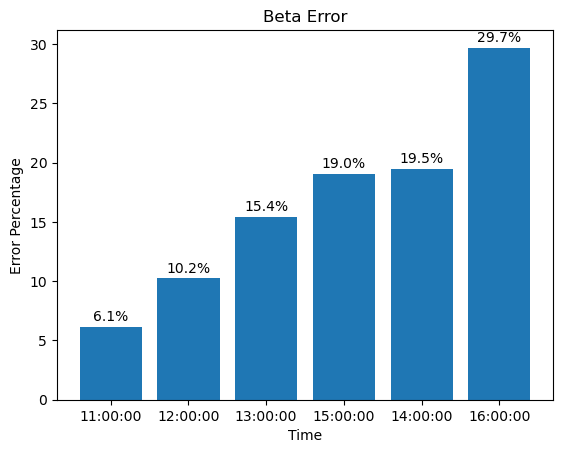

In [137]:
import matplotlib.pyplot as plt

df = pd.read_csv('time_id_reference.csv')

All_beta_list = Tesla_beta_list + Invesco_beta_list + Netflix_beta_list + jpm_beta_list + Goldman_beta_list + Google_beta_list + Facebook_beta_list + Amazon_beta_list + Apple_beta_list

dict_time = {}
for time_id in All_beta_list:
    time_row = df[df['time_id'] == time_id]
    time = time_row.iloc[0]['time']
    if time in dict_time.keys():
        dict_time[time] += 1
    else:
        dict_time[time] = 1

print(dict_time)

# Sort the keys based on their values
keys = sorted(dict_time.keys(), key=lambda x: dict_time[x])
values = [dict_time[key] for key in keys]

# Calculate the total count
total_count = sum(values)

# Calculate the percentage for each time count
percentages = [(count / total_count) * 100 for count in values]
print(percentages)

# Plot the percentages for dict_time
plt.bar(keys, percentages)
plt.xlabel('Time')
plt.ylabel('Error Percentage')
plt.title('Beta Error')

# Add values on top of the bars
for i, v in enumerate(percentages):
    plt.text(keys[i], v + 0.5, f'{v:.1f}%', ha='center')
    
plt.show()


# SPY Performance metrics:

In [90]:
def calculate_performance_SPY(data, train, stock_id):
    modelled_vol = []
    y_true = train.loc[train['stock_id'] == stock_id]
    spy_vol_prev = 0
    beta_dir_error_list = []
    y_true_indexed = y_true.set_index('time_id')
    for tID in y_true['time_id']:
        base_vol = ewma(data, stock_id, tID).mean()
        beta_factor = 0
        generated_vol = base_vol + beta_factor
        modelled_vol.append(generated_vol)
        if ((generated_vol - base_vol >= 0) != (y_true_indexed.at[tID, 'target'] - base_vol >= 0)):
            beta_dir_error_list.append(tID)
            
    r2_score_val = round(r2_score(y_true=y_true['target'], y_pred=modelled_vol), 3)
    rmspe_val = round(rmspe(y_true=y_true['target'], y_pred=modelled_vol), 3)
    beta_dir_effectiveness = round(len(beta_dir_error_list) / len(y_true), 3)
    
    return r2_score_val, rmspe_val, beta_dir_effectiveness, modelled_vol, beta_dir_error_list

In [91]:
stockId = 50200
spy_R2_new, spy_RMSPE_new, spy_beta_eff_new, spy_modelled_vol_new, spy_beta_error_list = calculate_performance_SPY(data, train, stockId)
print(spy_R2_new, spy_RMSPE_new, spy_beta_eff_new)

0.809 0.219 0.45


# R2 Scores for Companies with Local Beta graph

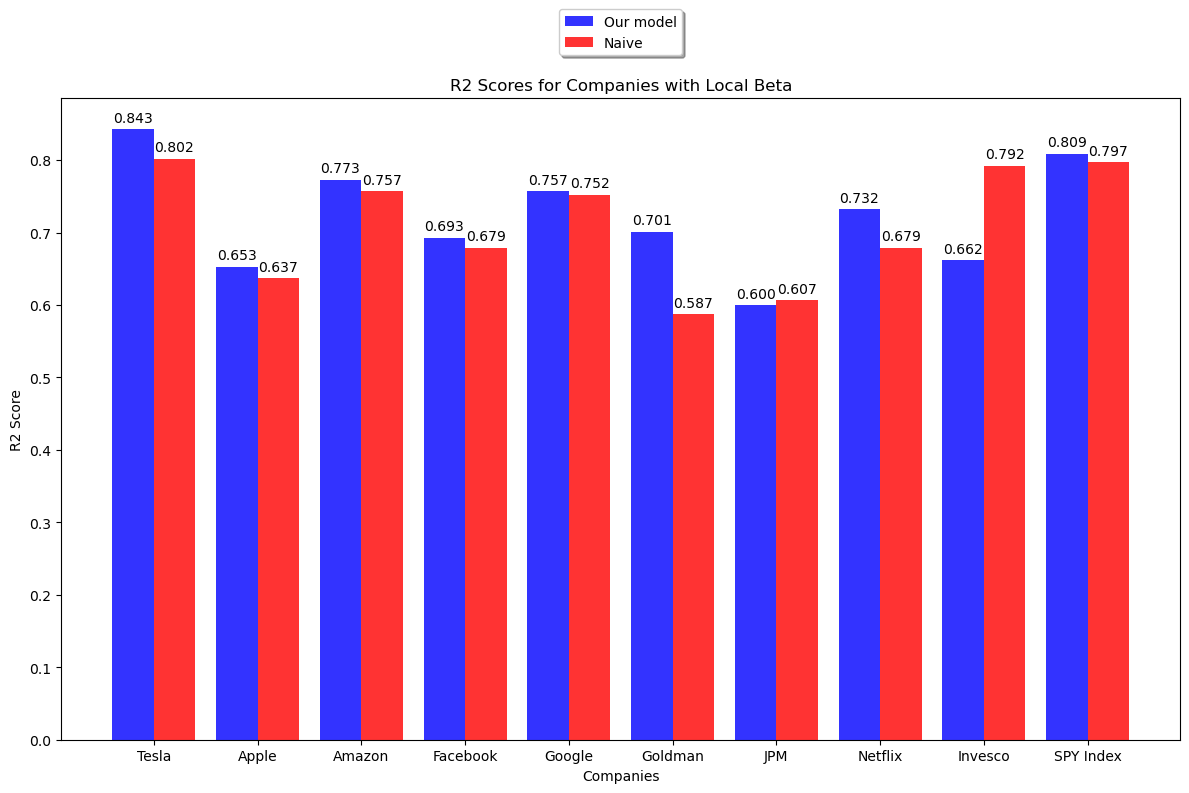

In [100]:
import matplotlib.pyplot as plt

Tesla_R2_scores = [Tesla_R2, 0.802]
Apple_R2_scores = [Apple_R2, 0.637]
Amazon_R2_scores = [Amazon_R2, 0.757]
Facebook_R2_scores = [Facebook_R2, 0.679]
Google_R2_scores = [Google_R2, 0.752]
Goldman_R2_scores = [Goldman_R2, 0.587]
jpm_R2_scores = [jpm_R2, 0.607]
Netflix_R2_scores = [netflix_R2, 0.679]
Invesco_R2_scores = [invesco_R2, 0.792]
spy_R2_scores = [0.809, 0.797]

# Data for R2 scores
companies = ['Tesla', 'Apple', 'Amazon', 'Facebook', 'Google', 'Goldman', 'JPM', 'Netflix', 'Invesco', 'SPY Index']
R2_scores = [Tesla_R2_scores, Apple_R2_scores, Amazon_R2_scores, Facebook_R2_scores, Google_R2_scores, Goldman_R2_scores, jpm_R2_scores, Netflix_R2_scores, Invesco_R2_scores, spy_R2_scores]

# Extracting R2 scores and reference values
R2 = [x[0] for x in R2_scores]
ref = [x[1] for x in R2_scores]

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 8))
index = range(len(companies))
bar_width = 0.4  # increased bar width
opacity = 0.8

# Plotting R2 scores
rects1 = plt.bar(index, R2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Our model')

# Plotting reference values
rects2 = plt.bar([i + bar_width for i in index], ref, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Naive')

# Adding labels and legends
plt.xlabel('Companies')
plt.ylabel('R2 Score')
plt.title('R2 Scores for Companies with Local Beta')
plt.xticks([i + bar_width/2 for i in index], companies)
plt.legend()

# Adding values on top of bars
for i in index:
    plt.text(rects1[i].get_x() + rects1[i].get_width() / 2, rects1[i].get_height() + 0.01, f'{R2[i]:.3f}', ha='center', color='black')

for i in index:
    plt.text(rects2[i].get_x() + rects2[i].get_width() / 2, rects2[i].get_height() + 0.01, f'{ref[i]:.3f}', ha='center', color='black')
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

# Displaying the graph
plt.tight_layout()
plt.show()


 # RMSPE Scores for Companies with local beta graph

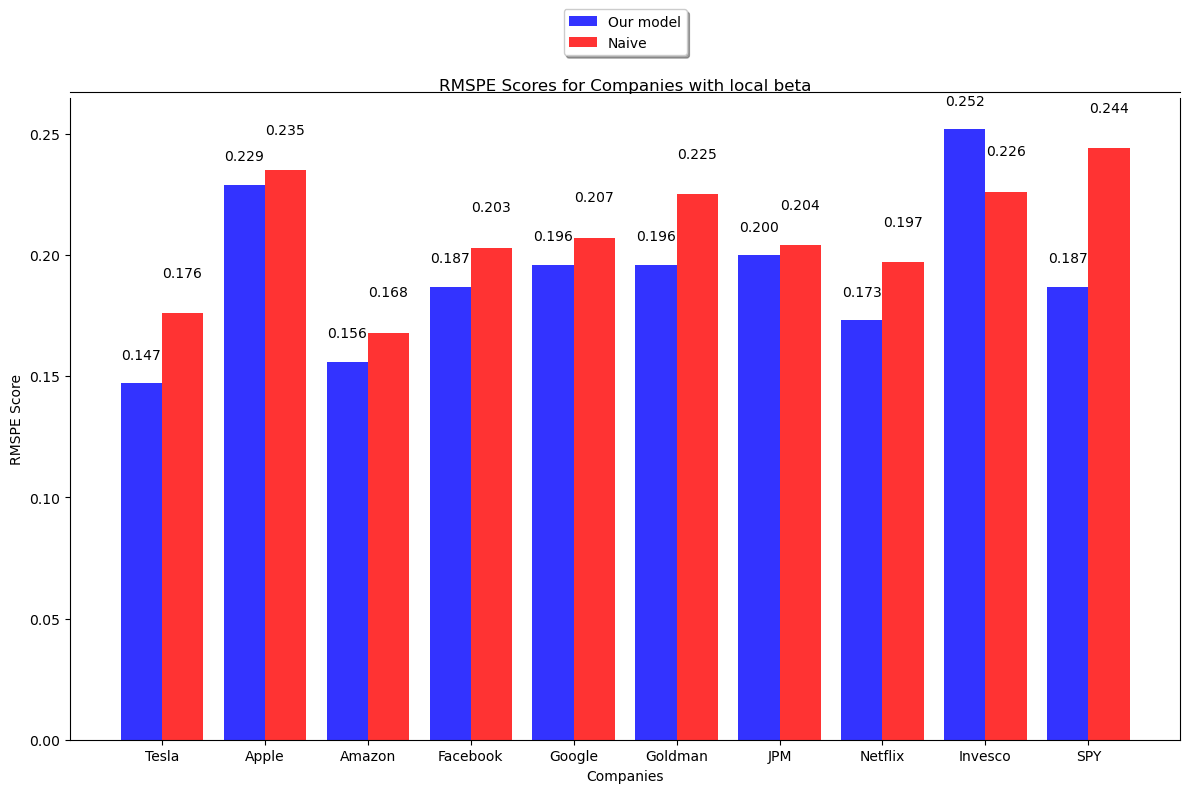

In [107]:
import matplotlib.pyplot as plt

# Your data
Tesla_RMSPE_scores = [Tesla_RMSPE, 0.176]
Apple_RMSPE_scores = [Apple_RMSPE, 0.235]
Amazon_RMSPE_scores = [Amazon_RMSPE, 0.168]
Facebook_RMSPE_scores = [Facebook_RMSPE, 0.203]
Google_RMSPE_scores = [Google_RMSPE, 0.207]
Goldman_RMSPE_scores = [Goldman_RMSPE, 0.225]
jpm_RMSPE_scores = [jpm_RMSPE, 0.204]
Netflix_RMSPE_scores = [netflix_RMSPE, 0.197]
Invesco_RMSPE_scores = [invesco_RMSPE, 0.226]
spy_RMSPE_scores = [0.187, 0.244]

# Data for RMSPE scores
companies = ['Tesla', 'Apple', 'Amazon', 'Facebook', 'Google', 'Goldman', 'JPM', 'Netflix', 'Invesco', 'SPY']
RMSPE_scores = [Tesla_RMSPE_scores, Apple_RMSPE_scores, Amazon_RMSPE_scores, Facebook_RMSPE_scores, Google_RMSPE_scores, Goldman_RMSPE_scores, jpm_RMSPE_scores, Netflix_RMSPE_scores, Invesco_RMSPE_scores, spy_RMSPE_scores]

# Extracting RMSPE scores and reference values
RMSPE = [x[0] for x in RMSPE_scores]
ref_RMSPE = [x[1] for x in RMSPE_scores]

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 8))
index = range(len(companies))
bar_width = 0.4
opacity = 0.8

# Plotting RMSPE scores
rects1 = plt.bar(index, RMSPE, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Our model')

# Plotting reference values
rects2 = plt.bar([i + bar_width for i in index], ref_RMSPE, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Naive')

# Adding labels and legends
plt.xlabel('Companies')
plt.ylabel('RMSPE Score')
plt.title('RMSPE Scores for Companies with local beta')
plt.xticks([i + bar_width/2 for i in index], companies)
plt.legend()

# Adding values on top of bars
for i in index:
    plt.text(rects1[i].get_x() + rects1[i].get_width() / 2, rects1[i].get_height() + 0.01, f'{RMSPE[i]:.3f}', ha='center', color='black')

for i in index:
    plt.text(rects2[i].get_x() + rects2[i].get_width() / 2, rects2[i].get_height() + 0.015, f'{ref_RMSPE[i]:.3f}', ha='center', color='black') # Adjusted the y-coordinate

ax.spines['top'].set_position(('axes', 1.01))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
    
# Displaying the graph
plt.tight_layout()
plt.show()


# R2 Scores for Companies with global beta graph

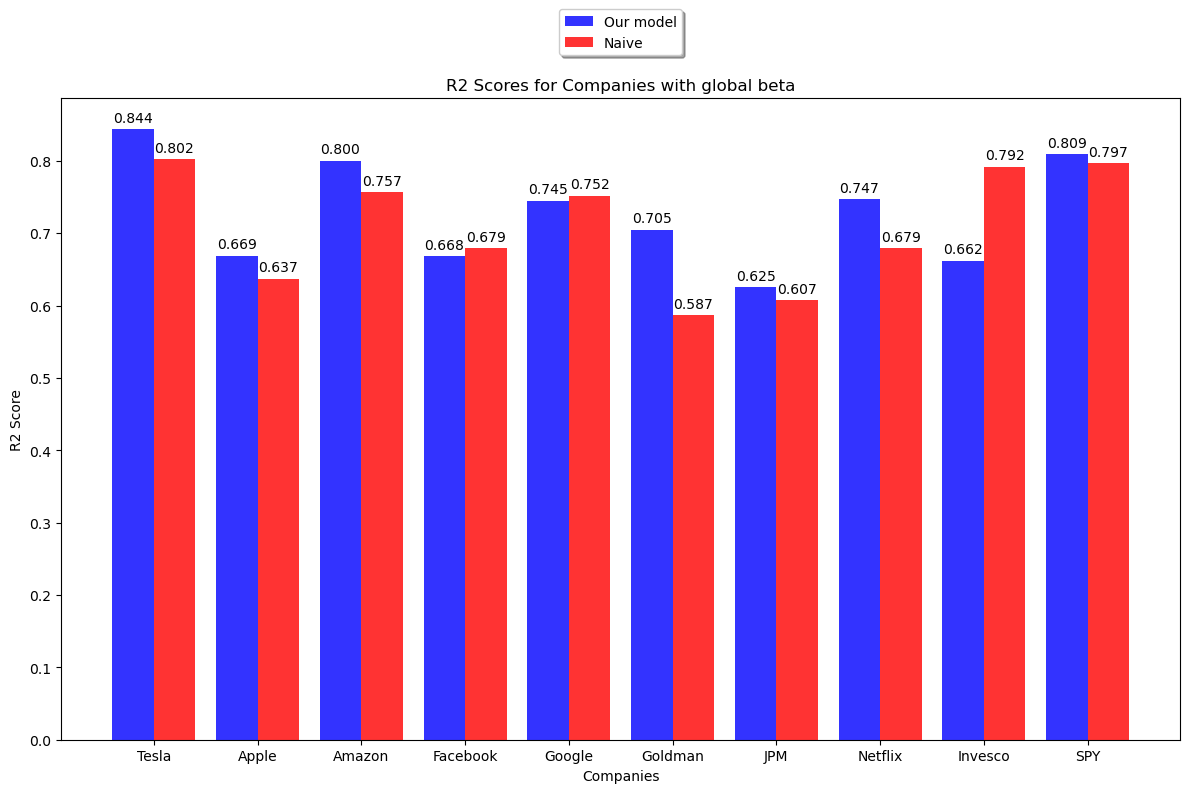

In [110]:
# Graph without local beta
import matplotlib.pyplot as plt

Tesla_R2_scores_new = [Tesla_R2_new, 0.802]
Apple_R2_scores_new = [Apple_R2_new, 0.637]
Amazon_R2_scores_new = [Amazon_R2_new, 0.757]
Facebook_R2_scores_new = [Facebook_R2_new, 0.679]
Google_R2_scores_new = [Google_R2_new, 0.752]
Goldman_R2_scores_new = [Goldman_R2_new, 0.587]
jpm_R2_scores_new = [jpm_R2_new, 0.607]
Netflix_R2_scores_new = [netflix_R2_new, 0.679]
Invesco_R2_scores_new = [invesco_R2_new, 0.792]
spy_R2_scores = [0.809, 0.797]

# Data for R2 scores
companies = ['Tesla', 'Apple', 'Amazon', 'Facebook', 'Google', 'Goldman', 'JPM', 'Netflix', 'Invesco', 'SPY']
R2_scores_new = [Tesla_R2_scores_new, Apple_R2_scores_new, Amazon_R2_scores_new, Facebook_R2_scores_new, Google_R2_scores_new, Goldman_R2_scores_new, jpm_R2_scores_new, Netflix_R2_scores_new, Invesco_R2_scores_new, spy_R2_scores]

# Extracting R2 scores and reference values
R2_new = [x[0] for x in R2_scores_new]
ref_new = [x[1] for x in R2_scores_new]

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 8))
index = range(len(companies))
bar_width = 0.4
opacity = 0.8

# Plotting R2 scores
rects1 = plt.bar(index, R2_new, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Our model')

# Plotting reference values
rects2 = plt.bar([i + bar_width for i in index], ref_new, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Naive')

# Adding labels and legends
plt.xlabel('Companies')
plt.ylabel('R2 Score')
plt.title('R2 Scores for Companies with global beta')
plt.xticks([i + bar_width/2 for i in index], companies)
plt.legend()

# Adding values on top of bars
for i in index:
    plt.text(rects1[i].get_x() + rects1[i].get_width() / 2, rects1[i].get_height() + 0.01, f'{R2_new[i]:.3f}', ha='center', color='black')

for i in index:
    plt.text(rects2[i].get_x() + rects2[i].get_width() / 2, rects2[i].get_height() + 0.01, f'{ref_new[i]:.3f}', ha='center', color='black')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
    
# Displaying the graph
plt.tight_layout()
plt.show()

# RMSPE Scores for Companies with global beta graph

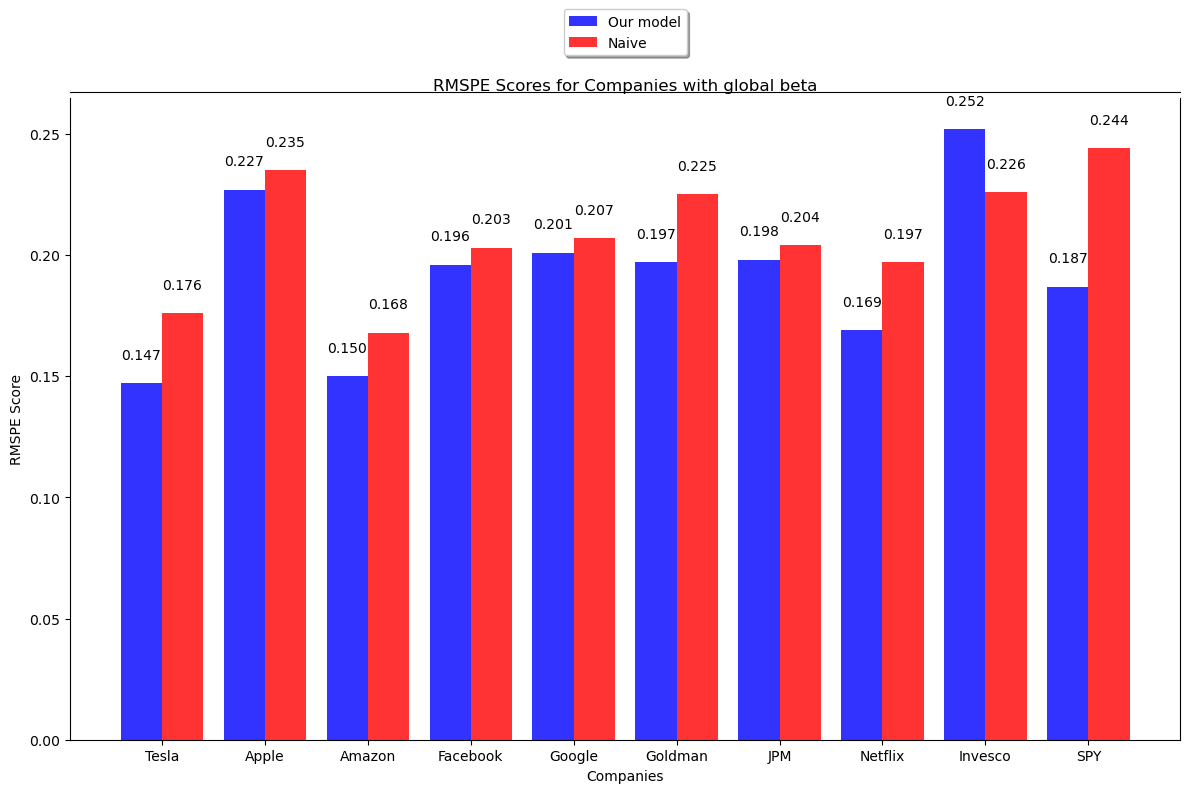

In [135]:
# Graph with local beta
import matplotlib.pyplot as plt

Tesla_RMSPE_scores_new = [Tesla_RMSPE_new, 0.176]
Apple_RMSPE_scores_new = [Apple_RMSPE_new, 0.235]
Amazon_RMSPE_scores_new = [Amazon_RMSPE_new, 0.168]
Facebook_RMSPE_scores_new = [Facebook_RMSPE_new, 0.203]
Google_RMSPE_scores_new = [Google_RMSPE_new, 0.207]
Goldman_RMSPE_scores_new = [Goldman_RMSPE_new, 0.225]
jpm_RMSPE_scores_new = [jpm_RMSPE_new, 0.204]
Netflix_RMSPE_scores_new = [netflix_RMSPE_new, 0.197]
Invesco_RMSPE_scores_new = [invesco_RMSPE_new, 0.226]
spy_RMSPE_scores = [0.187, 0.244]

# Data for R2 scores
companies = ['Tesla', 'Apple', 'Amazon', 'Facebook', 'Google', 'Goldman', 'JPM', 'Netflix', 'Invesco', 'SPY']
RMSPE_scores_new = [Tesla_RMSPE_scores_new, Apple_RMSPE_scores_new, Amazon_RMSPE_scores_new, Facebook_RMSPE_scores_new, Google_RMSPE_scores_new, Goldman_RMSPE_scores_new, jpm_RMSPE_scores_new, Netflix_RMSPE_scores_new, Invesco_RMSPE_scores_new, spy_RMSPE_scores]

# Extracting R2 scores and reference values
RMSPE_new = [x[0] for x in RMSPE_scores_new]
ref_RMSPE_new = [x[1] for x in RMSPE_scores_new]

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 8))
index = range(len(companies))
bar_width = 0.4
opacity = 0.8

# Plotting RMSPE scores
rects1 = plt.bar(index, RMSPE_new, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Our model')

# Plotting reference values
rects2 = plt.bar([i + bar_width for i in index], ref_RMSPE_new, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Naive')

# Adding labels and legends
plt.xlabel('Companies')
plt.ylabel('RMSPE Score')
plt.title('RMSPE Scores for Companies with global beta')
plt.xticks([i + bar_width/2 for i in index], companies)
plt.legend()

# Adding values on top of bars
for i in index:
    plt.text(rects1[i].get_x() + rects1[i].get_width() / 2, rects1[i].get_height() + 0.01, f'{RMSPE_new[i]:.3f}', ha='center', color='black')

for i in index:
    plt.text(rects2[i].get_x() + rects2[i].get_width() / 2, rects2[i].get_height() + 0.01, f'{ref_RMSPE_new[i]:.3f}', ha='center', color='black')

ax.spines['top'].set_position(('axes', 1.01))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
    
# Displaying the graph
plt.tight_layout()
plt.show()

# Overall R2 score of model with global Beta

In [83]:
allR2 = []
for i in range (1152):
    allR2.append(Tesla_modelled_vol_new[i])
    allR2.append(Apple_modelled_vol_new[i])
    allR2.append(Amazon_modelled_vol_new[i])
    allR2.append(Google_modelled_vol_new[i])
    allR2.append(jpm_modelled_vol_new[i])
    allR2.append(Netflix_modelled_vol_new[i])
    allR2.append(Facebook_modelled_vol_new[i])
    allR2.append(Goldman_modelled_vol_new[i])
    allR2.append(spy_modelled_vol_new[i])
    allR2.append(invesco_modelled_vol_new[i])
r2_score_val = round(r2_score(y_true=train['target'], y_pred=allR2), 3)
rmspe_val = round(rmspe(y_true=train['target'], y_pred=allR2), 3)
print(r2_score_val, rmspe_val)

0.865 0.198


# Overall R2 score of model with local Beta

In [84]:
allR2_new = []
for i in range (1152):
    allR2_new.append(Tesla_modelled_vol[i])
    allR2_new.append(Apple_modelled_vol[i])
    allR2_new.append(Amazon_modelled_vol[i])
    allR2_new.append(Google_modelled_vol[i])
    allR2_new.append(jpm_modelled_vol[i])
    allR2_new.append(Netflix_modelled_vol[i])
    allR2_new.append(Facebook_modelled_vol[i])
    allR2_new.append(Goldman_modelled_vol[i])
    allR2_new.append(spy_modelled_vol_new[i])
    allR2_new.append(invesco_modelled_vol[i])
r2_score_val_new = round(r2_score(y_true=train['target'], y_pred=allR2_new), 3)
rmspe_val_new = round(rmspe(y_true=train['target'], y_pred=allR2_new), 3)
print(r2_score_val_new, rmspe_val_new)

0.864 0.198


# Graph comparing overall R2 scores of Naive and our models

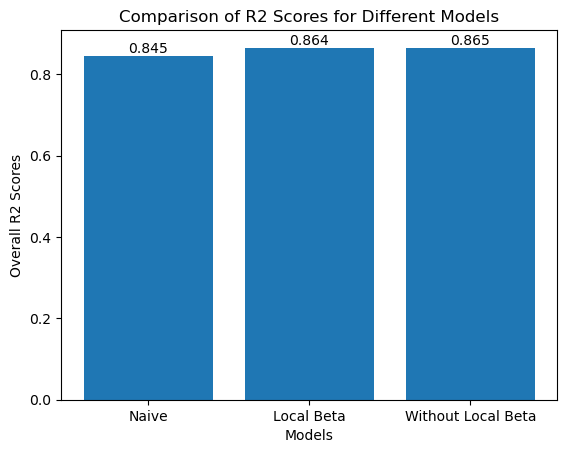

In [1]:
import matplotlib.pyplot as plt

Overall_R2_scores = [0.845, 0.864, 0.865]
x_labels = ['Naive', 'Local Beta', 'Without Local Beta']

# Create a bar chart
plt.bar(x_labels, Overall_R2_scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Overall R2 Scores')
plt.title('Comparison of R2 Scores for Different Models')

# Add values on top of the bars
for i in range(len(x_labels)):
    plt.text(x_labels[i], Overall_R2_scores[i], str(Overall_R2_scores[i]), ha='center', va='bottom')

# Show the plot
plt.show()